In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from util import GMMModel

from keras import layers, models, optimizers

import torch.nn
import torch.optim
import torch.utils.data

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Generate random $f, \vec{\mu}, C$ for each Gaussian model, where the model is <br><br>
$M_{ij} = \sum_{k=1}^{n=ngauss} f G_k(\mu_1, \mu_2, \sigma_1, \sigma_2, \rho)$ <br><br>
Set $f = 1, \sigma_1 = \sigma_2 = 0.2, \rho = 0.5$ for each GMM. <br><br>
Simulate $D_{ij} = M_{ij} + N_{ij}$, where $N_{ij} \sim G(\sigma = W_{ij}^{-0.5}).$ 

In [2]:
def data_sample(x1, x2, gen, ngauss=1, n=1000):
    
    x1_edges, x2_edges = np.arange(0, x1), np.arange(0, x2)

    x1_mid = len(x1_edges) // 2
    x2_mid = len(x2_edges) // 2
    
    GMM = GMMModel(x1_edges, x2_edges)
    
    data_shape = (n, ) + (len(x1_edges)-1, len(x2_edges)-1)
    params_shape = (n, 2*ngauss) 
    
    data = np.zeros(shape=data_shape)
    params = np.zeros(shape=params_shape)
    
    for i in range(n):
        for g in range(ngauss):
              
            f = 1. / ngauss
            sigma1, sigma2, rho = 5., 5., 0.5

            mu1 = gen.uniform(low=x1_edges[x1_mid-15], high=x1_edges[x1_mid+15])
            mu2 = gen.uniform(low=x2_edges[x2_mid-15], high=x2_edges[x2_mid+15])

            gmm_params = np.array([f, mu1, mu2, sigma1, sigma2, rho])
            
            model = GMM.predict(gmm_params, compute_partials=False)
            noise = gen.normal(loc=0.0, scale=0.0001, size=(model.shape))
            
            data[i] += model + noise
            
            params[i, 2*g:2*(g+1)] = gmm_params[1:3].reshape(2)
        
    # Flatten the data
    data = data.reshape(n, -1)
    
    return (data, params)

Generate training and testing data

In [3]:
N_train, N_test = 80000, 80000
gen = np.random.RandomState(seed=123)

x_train, y_train = data_sample(41, 41, gen, ngauss=1, n=N_train)
x_test, y_test = data_sample(41, 41, gen, ngauss=1, n=N_test)

# For Keras
x_train_keras, y_train_keras = np.copy(x_train), np.copy(y_train) 
x_test_keras, y_test_keras = np.copy(x_test), np.copy(y_test) 

# For torch
x_train_torch, y_train_torch = torch.tensor(x_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)) 
x_test_torch, y_test_torch = torch.tensor(x_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)) 

torch_train_data = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
torch_test_data = torch.utils.data.TensorDataset(x_test_torch, y_test_torch)

In [4]:
def plot_data(x, y, seed=123):
    
    gen = np.random.RandomState(seed=seed)
    arg = gen.randint(0, x.shape[0])
    
    size = int(np.sqrt(x.shape[1]))
    
    plt.imshow(x[arg].reshape(size, size), origin='lower')
    plt.plot(*y[arg], 'x', ms=25)
    plt.xlabel('$\mu_1$')
    plt.ylabel('$\mu_2$')

def plot_multiple_data(x, y, y_pred, n=5, seed=123):
    
    gen = np.random.RandomState(seed=seed)
  
    args_to_plot = np.arange(0, x.shape[0])
    gen.shuffle(args_to_plot)
    args_to_plot = args_to_plot[:n**2]
    
    x_ = x[args_to_plot]
    y_ = y[args_to_plot]
    y_pred_ = y_pred[args_to_plot] 
    
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex='col', sharey='row', figsize=(15, 15))
    fig.text(0.5, 0.04, '$\mu_1$', ha='center')
    fig.text(0.04, 0.5, '$\mu_2$', va='center', rotation='vertical')
    size = int(np.sqrt(x.shape[1]))
    
    for i, data in enumerate(zip(x_, y_, y_pred_)):
        if i > 25: break
            
        idx, j = i % n, i // n
    
        axs[idx, j].imshow(data[0].reshape(size, size), origin='lower')
        axs[idx, j].plot(*data[1], '+', ms=25)

        if np.all(data[2]):
            axs[idx, j].plot(*data[2], 'x', ms=25)

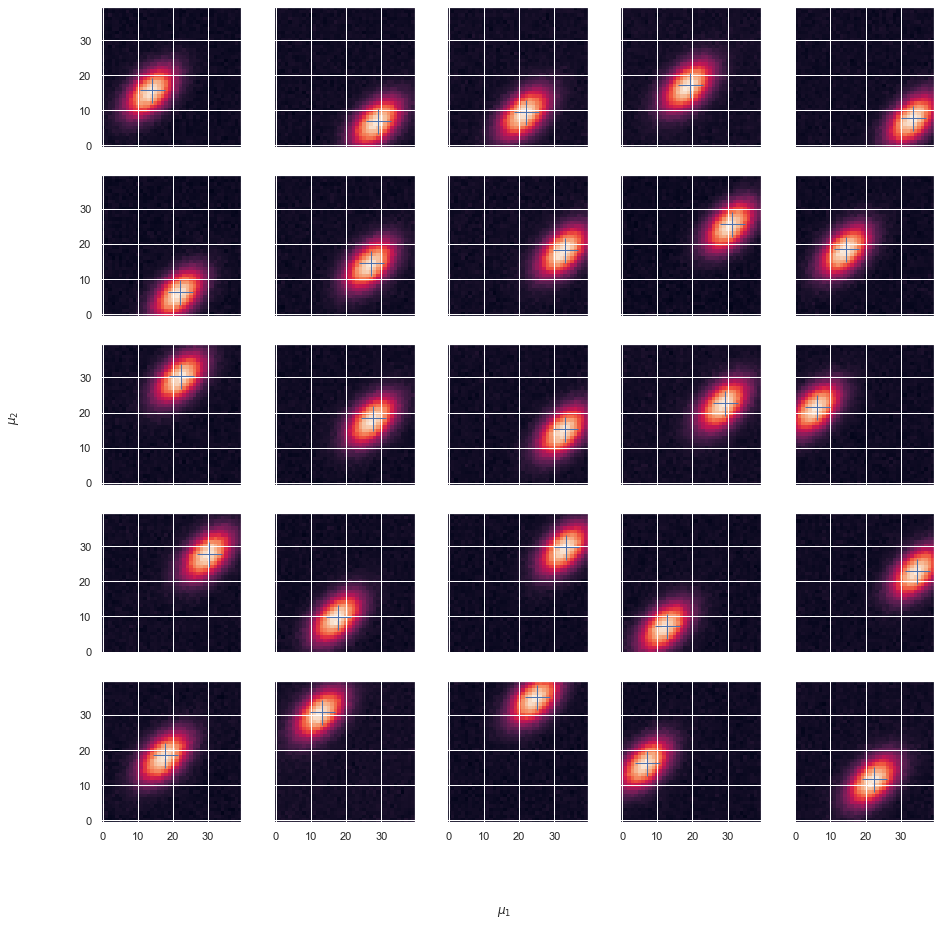

In [5]:
# Sample image
plot_multiple_data(x_train, y_train, np.zeros(y_train.shape), n=5)

Training sample $D_{ij} \to \vec{\mu}$ using Keras

In [6]:
class DNN_Keras(models.Sequential):
    
    def __init__(self, Nin, Nh_l, Pd_l, Nout, learning_rate=0.01):
        super(DNN_Keras, self).__init__()
        
        assert len(Nh_l) == len(Pd_l)
        
        for h in range(len(Nh_l)):
            if h == 0:
                self.add(layers.Dense(Nh_l[h], activation='relu', input_shape=(Nin, ), name='Hidden-1'))
            else:
                self.add(layers.Dense(Nh_l[h], activation='relu', name='Hidden-'+str(h+1)))
                
            self.add(layers.Dropout(Pd_l[h]))
        
        self.add(layers.Dense(Nout))
        
        self.compile(loss='mse', optimizer=optimizers.Adam(lr=learning_rate))
        
def learn_keras(model, n_epochs=100, batch_size=200, validation_split=0.50):
    
    history = model.fit(x_train_keras, y_train_keras, epochs=n_epochs, batch_size=batch_size,
                        validation_split=validation_split, verbose=2, shuffle=True)
    
    performance = model.evaluate(x_test_keras, y_test_keras, batch_size=200)
    y_pred_keras = model.predict(x_test_keras)
    
    return history, performance, y_pred_keras

def plot_loss(history):
    plt.plot(history.history['loss'], '.', label='Train')
    plt.plot(history.history['val_loss'], '.', label='Test')
    plt.title('Model Loss')
    plt.yscale('log')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc=0)

Define NN hyper-parameters

In [7]:
Nh_l = [100 for _ in range(2)]
Pd_l = [0.05 for _ in range(len(Nh_l))]
Nout = y_train_keras.shape[1]

nn_keras = DNN_Keras(x_train_keras.shape[1], Nh_l, Pd_l, Nout)

Train on 40000 samples, validate on 40000 samples
Epoch 1/100
 - 7s - loss: 38.7266 - val_loss: 0.2239
Epoch 2/100
 - 2s - loss: 1.7251 - val_loss: 0.1044
Epoch 3/100
 - 3s - loss: 1.5410 - val_loss: 0.0772
Epoch 4/100
 - 3s - loss: 1.4624 - val_loss: 0.1098
Epoch 5/100
 - 2s - loss: 1.4130 - val_loss: 0.0576
Epoch 6/100
 - 3s - loss: 1.3410 - val_loss: 0.0582
Epoch 7/100
 - 3s - loss: 1.2858 - val_loss: 0.0479
Epoch 8/100
 - 2s - loss: 1.2508 - val_loss: 0.1031
Epoch 9/100
 - 2s - loss: 1.1892 - val_loss: 0.1044
Epoch 10/100
 - 2s - loss: 1.1845 - val_loss: 0.0577
Epoch 11/100
 - 3s - loss: 1.1743 - val_loss: 0.0603
Epoch 12/100
 - 3s - loss: 1.1419 - val_loss: 0.1978
Epoch 13/100
 - 2s - loss: 1.0978 - val_loss: 0.0529
Epoch 14/100
 - 2s - loss: 1.0773 - val_loss: 0.0564
Epoch 15/100
 - 2s - loss: 1.0598 - val_loss: 0.0962
Epoch 16/100
 - 2s - loss: 1.0058 - val_loss: 0.0520
Epoch 17/100
 - 2s - loss: 0.9609 - val_loss: 0.0543
Epoch 18/100
 - 3s - loss: 0.8996 - val_loss: 0.0469
Epoc

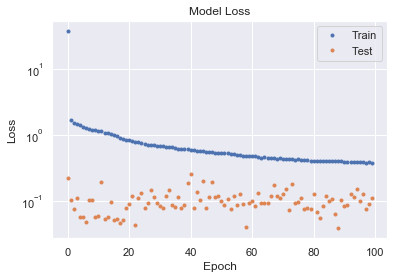

In [8]:
history, performance, y_pred_keras = learn_keras(nn_keras)

plot_loss(history)
print('Test loss ->', performance)

Check predicted $\vec{\mu}$.

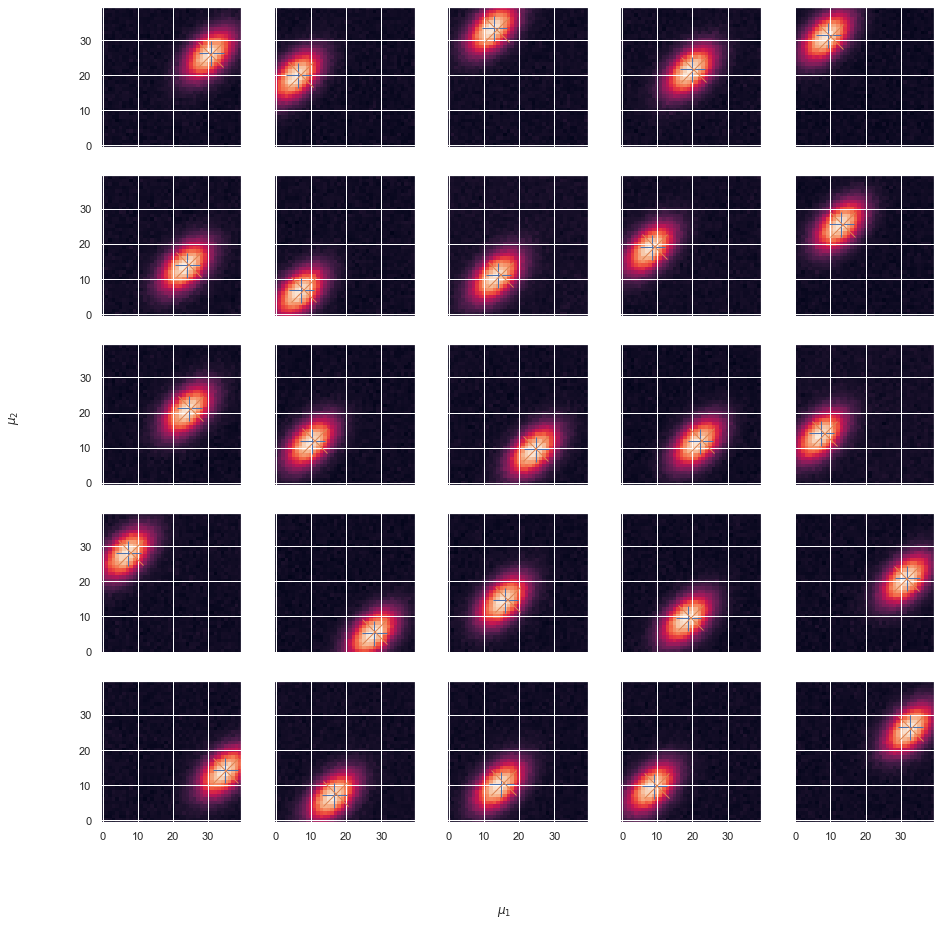

In [9]:
plot_multiple_data(x_test_keras, y_test_keras, y_pred_keras)

Training sample $(D_{ij}, W_{ij}) \to \vec{\mu}$ using torch

In [10]:
class DNN_Torch(torch.nn.Sequential):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU):
        super(DNN_Torch, self).__init__()
        
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        
        for depth, (n_inp, n_out) in enumerate(zip(n_inputs, n_outputs)):
            self.add_module(f'LYR{depth}', torch.nn.Linear(n_inp, n_out))
            
            if depth < len(n_inputs) - 1:
                self.add_module(f'ACT{depth}', activation())
            
            self.add_module(f'DRP{depth}', torch.nn.Dropout(p=0.05))

In [11]:
def learn(model, n_epochs=100, batch_size=200, learning_rate=0.05,
          loss_slice=slice(None, None), n_print=1):
    
    print(f'Model has {np.sum([np.prod(P.shape) for P in model.parameters()])} parameters.')
    loader = torch.utils.data.DataLoader(torch_train_data, batch_size=batch_size, shuffle=True)
    print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    x_test, y_test = torch_test_data.tensors
    train_loss, test_loss = list(), list()
    
    print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
    
    for epoch in range(n_epochs):
        model.train()
        
        for x_train, y_train in loader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred[:,loss_slice], y_train[:,loss_slice])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss.append(float(loss.data))
        model.eval()
        
        y_pred = model(x_test)
        test_loss.append(float(loss_fn(y_pred[:,loss_slice], y_test[:,loss_slice]).data))
        
        if epoch + 1 == print_at[0]:
            print(f'EPOCH {epoch + 1:5d}: TRAIN {train_loss[-1]:.5f} TEST {test_loss[-1]:.5f}')
            print_at = print_at[1:]
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, '.', label='TRAIN')
    plt.plot(test_loss, '.', label='TEST')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    
    return train_loss, test_loss, y_pred.detach()

Model has 190602 parameters.
Data has 128000000 values.
EPOCH   100: TRAIN 31.78993 TEST 1.41557


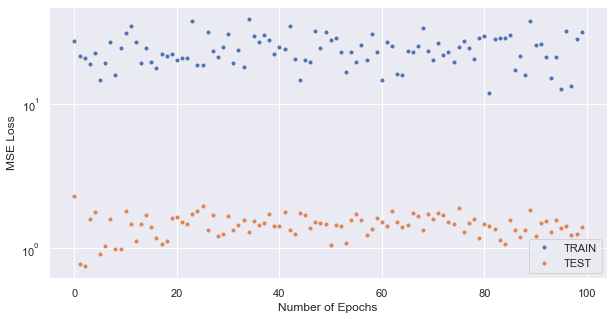

In [12]:
torch.manual_seed(123)
model = DNN_Torch(x_train_torch.shape[1], 100, 100, 100, 100, y_train.shape[1])
train_loss, test_loss, y_pred_torch = learn(model, learning_rate=0.01, n_epochs=100)

Check predicted $\vec{\mu}$.

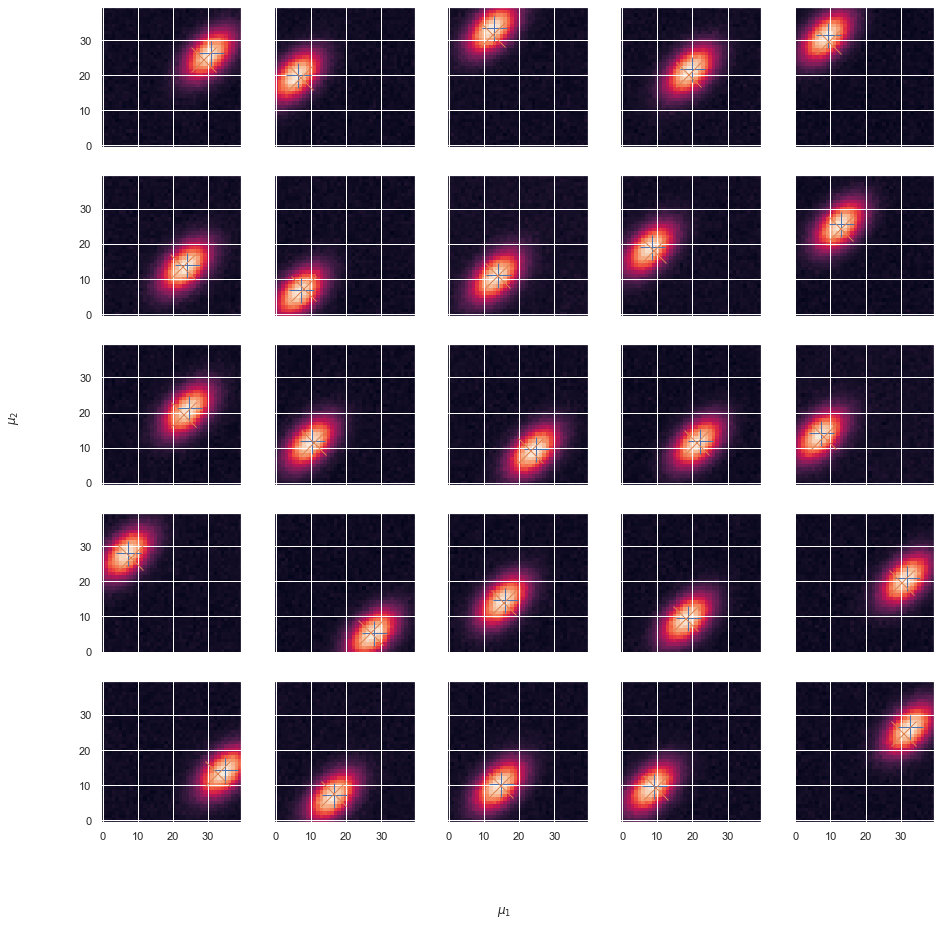

In [13]:
plot_multiple_data(x_test_torch.numpy(), y_test_torch.numpy(), y_pred_torch.numpy())